# Part 4 Time Series Forecasting Using ARIMA Modeling
By Josh Houlding

For this activity, in 500-750 words, answer the following:

1. Construct a time plot of the data and inspect the graph for any anomalies. This time plot should suggest whether any differencing is needed. Explain.
2. Use the autocorrelation and partial autocorrelation plots to identify and select the preliminary values of the autoregression (AR) order, p, the order of differencing, d, and the moving average order, q. Explain your findings.
3. Fit and train the ARIMA model based on your selected p, d, q values.
4. Evaluate your model statistically by interpreting its t-test, p values, R Squared, adjusted R squared, MAE, and MAPE. Interpret the results.
5. Forecast the next five periods and report the results.
6. Parameter Tuning: fit another ARIMA model with a different value(s) for the p, d, q parameters. Compare both models and interpret the findings. Which one is better in terms of white noise, variation, unusual patterns, trends, seasonality.., etc. Why?
7. Evaluate each model using the walk forward validation. Explain.

<b>Dataset:</b> Air Quality (UCI ML Repository) https://archive.ics.uci.edu/dataset/360/air+quality

In [28]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [29]:
# Load data
df = pd.read_excel("AirQualityUCI.xlsx")

# Set "date" as index
df.set_index("date", inplace=True)

# Task 1
Construct a time plot of the data and inspect the graph for any anomalies. This time plot should suggest whether any differencing is needed. Explain.

In [30]:
# Select relevant column groups for graphing
microgram_per_cubicmeter_columns = df[["true_nmhc", "true_benzene", "true_no2"]]
milligram_per_cubicmeter_columns = df[["true_co"]]
ppb_columns = df[["true_nox"]]
sensor_columns = df[["sensor_co", "sensor_nmhc", "sensor_nox", "sensor_no2", "sensor_o3"]]
# temp 
# rel hum
# abs hum

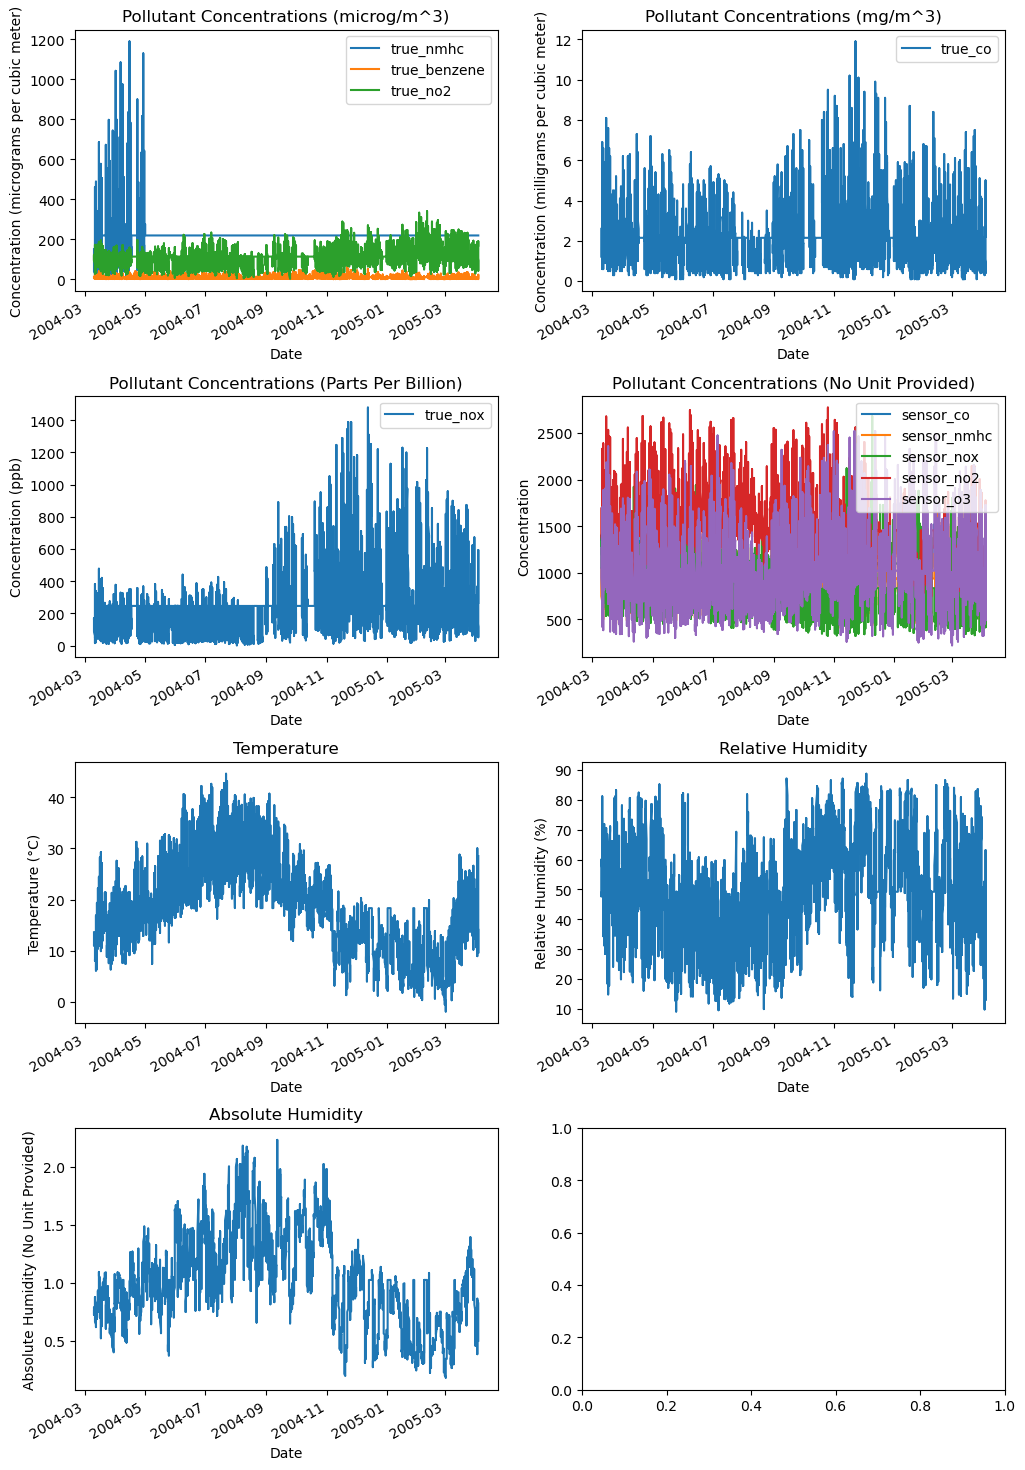

In [31]:
# Set up plot grid
fig, axes = plt.subplots(4, 2, figsize=(18, 10))
axes = axes.flatten()

# Graph levels of pollutants measured in microg/m^3 over time
microgram_per_cubicmeter_columns.plot(ax=axes[0], figsize=(12, 20))
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Concentration (micrograms per cubic meter)")
axes[0].set_title("Pollutant Concentrations (microg/m^3)")

# Graph levels of carbon monoxide (CO) over time (measured in mg/m^3) 
milligram_per_cubicmeter_columns.plot(ax=axes[1], figsize=(12, 20))
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Concentration (milligrams per cubic meter)")
axes[1].set_title("Pollutant Concentrations (mg/m^3)")

# Graph levels of nitric oxide (NOx) over time (measured in parts per billion)
ppb_columns.plot(ax=axes[2], figsize=(12, 20))
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Concentration (ppb)")
axes[2].set_title("Pollutant Concentrations (Parts Per Billion)")

# Graph sensor readings
sensor_columns.plot(ax=axes[3], figsize=(12, 20))
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Concentration")
axes[3].set_title("Pollutant Concentrations (No Unit Provided)")

# Graph temperature
df["temp"].plot(ax=axes[4], figsize=(12, 20))
axes[4].set_xlabel("Date")
axes[4].set_ylabel("Temperature (°C)")
axes[4].set_title("Temperature")

# Graph relative humidity
df["rel_humidity"].plot(ax=axes[5], figsize=(12, 20))
axes[5].set_xlabel("Date")
axes[5].set_ylabel("Relative Humidity (%)")
axes[5].set_title("Relative Humidity")

# Graph absolute humidity
df["abs_humidity"].plot(ax=axes[6], figsize=(12, 20))
axes[6].set_xlabel("Date")
axes[6].set_ylabel("Absolute Humidity (No Unit Provided)")
axes[6].set_title("Absolute Humidity")

# Show plot
plt.subplots_adjust(hspace=0.4)
plt.show()

Differencing is needed when the data shows trends or seasonality. We do see strong seasonality in temperature, relative humidity and absolute humidity, as well as mild seasonality in many of the pollutants (higher in the winter because of various factors like increased heating). Thus, it seems like differencing would be useful for removing the trends and seasonality from this data. 

# Task 2
Use the autocorrelation and partial autocorrelation plots to identify and select the preliminary values of the autoregression (AR) order, p, the order of differencing, d, and the moving average order, q. Explain your findings.

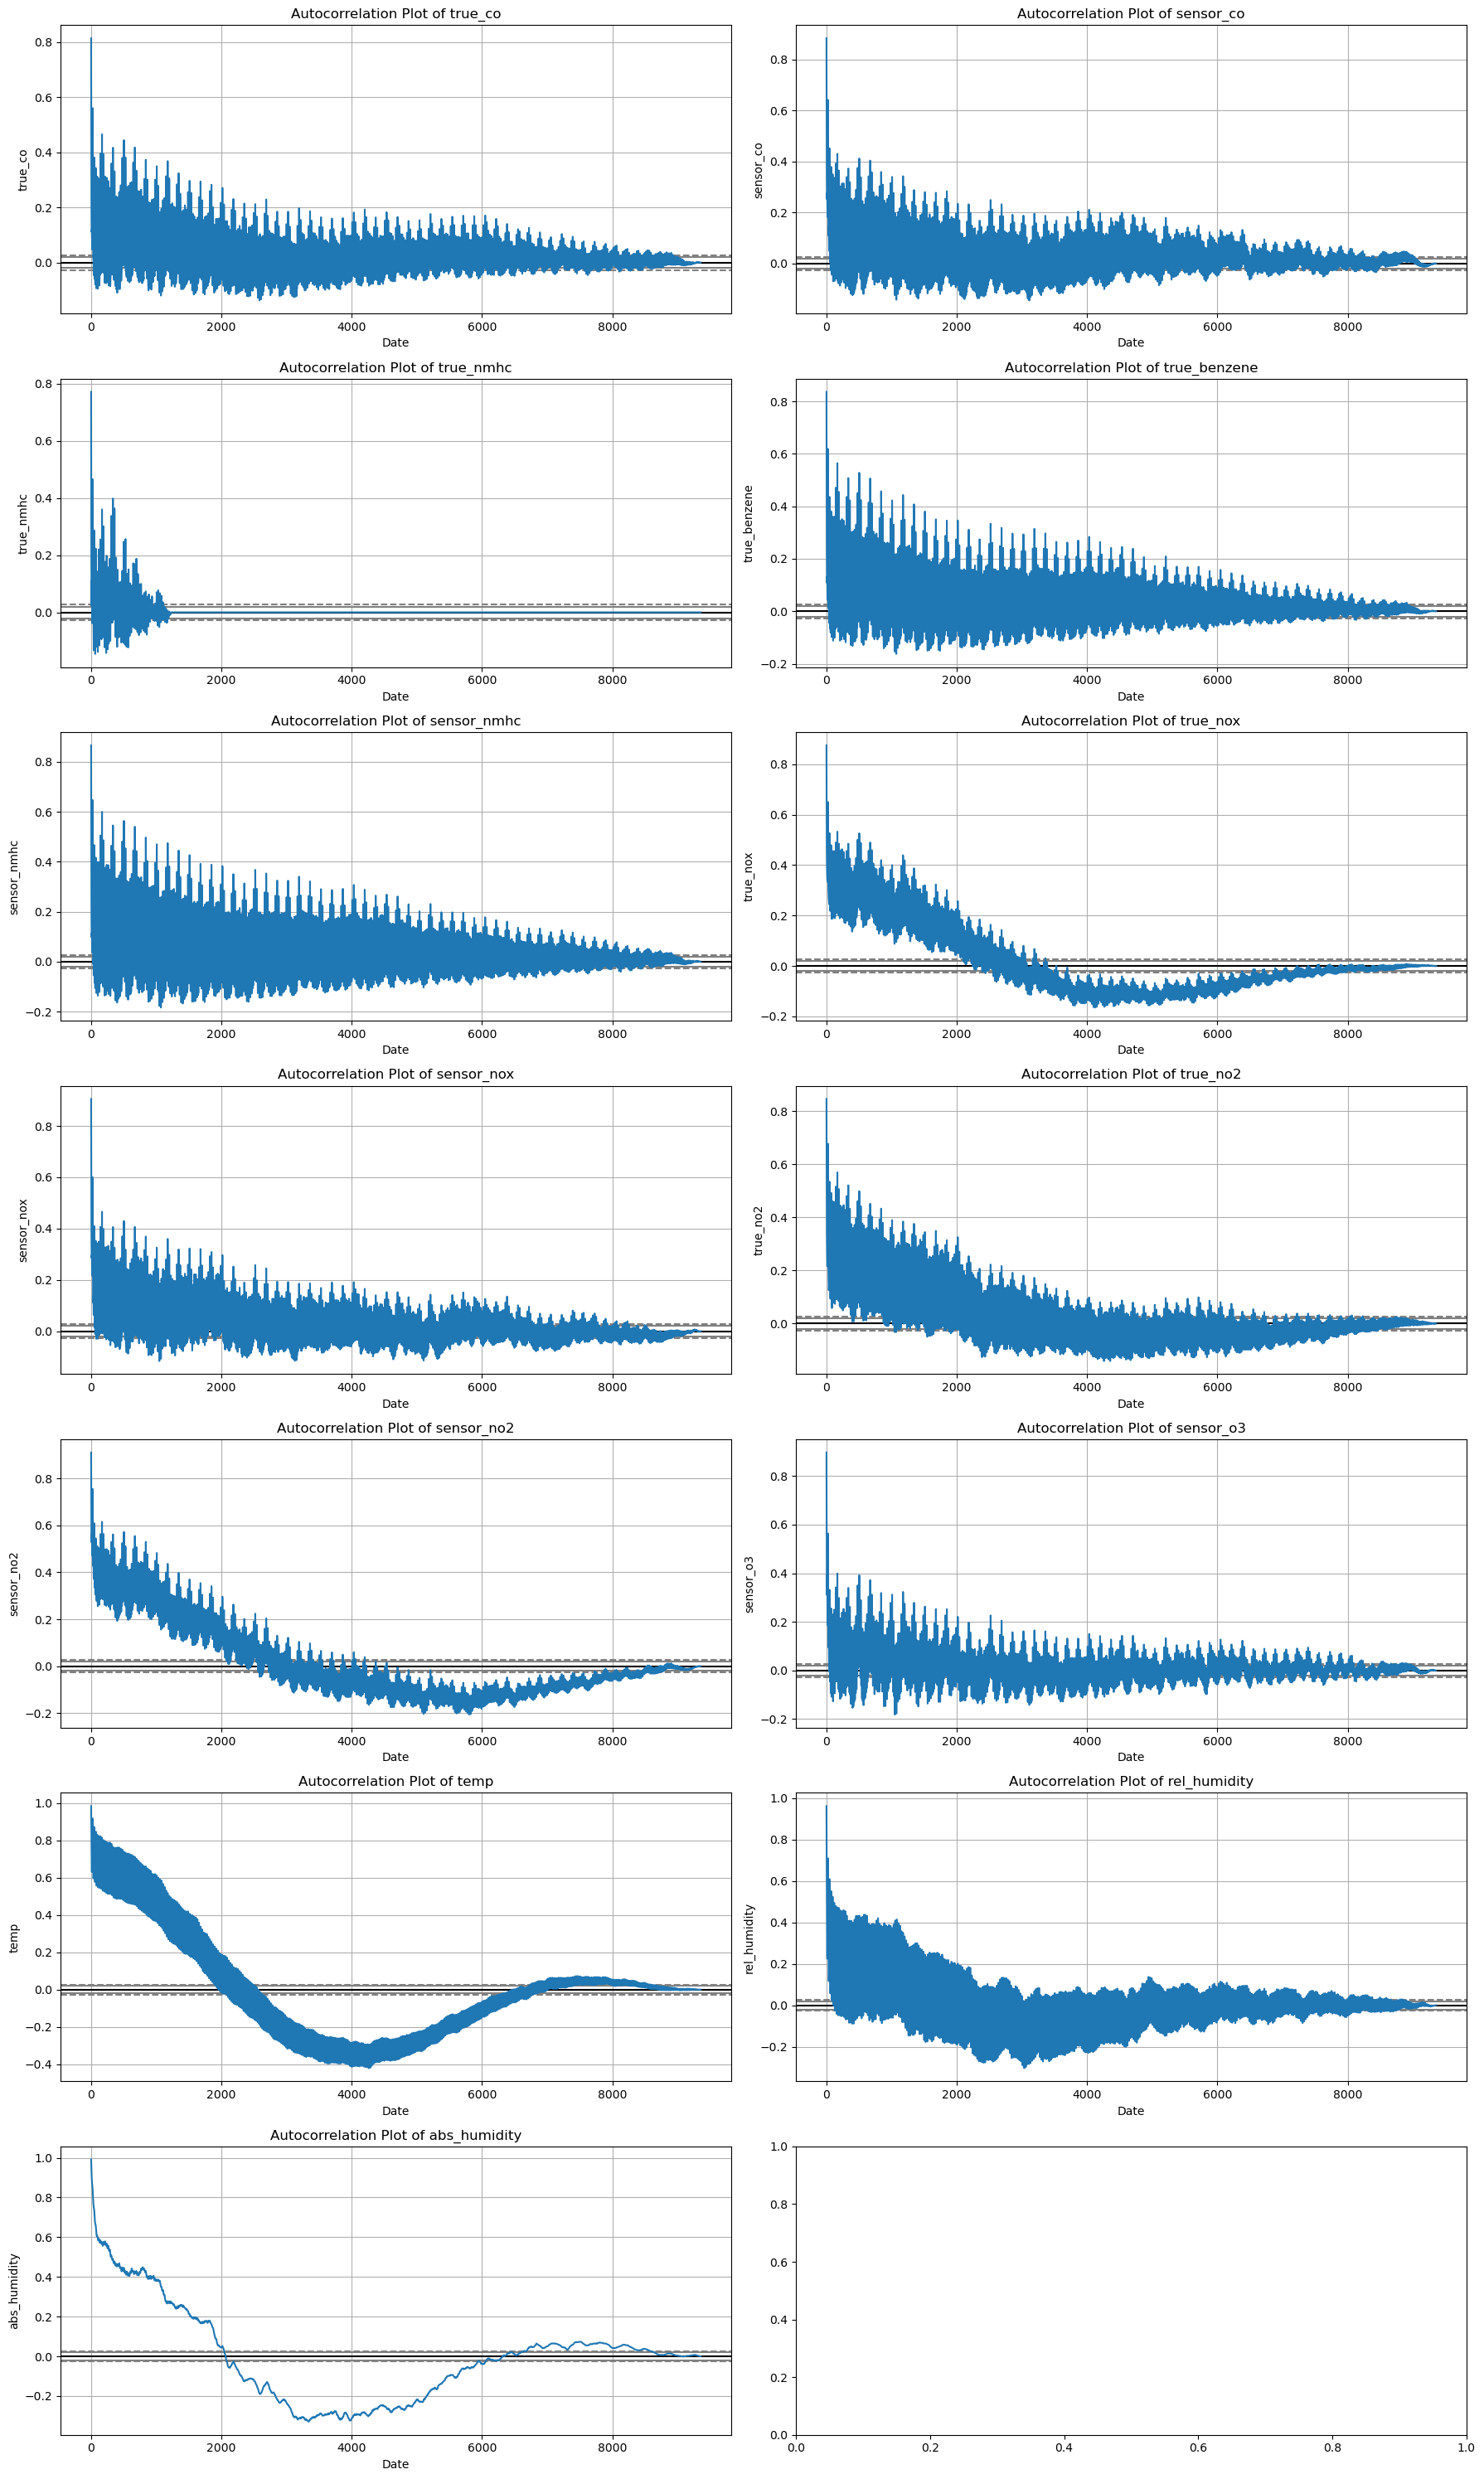

In [32]:
# Select original numeric columns for plotting
original_numeric_columns = df[["true_co", "sensor_co", "true_nmhc", "true_benzene", "sensor_nmhc", "true_nox", "sensor_nox", 
                               "true_no2", "sensor_no2", "sensor_o3", "temp", "rel_humidity", "abs_humidity"]]

# Create figure and grid
fig, axes = plt.subplots(7, 2, figsize=(18, 30))
axes = axes.flatten()

# Create autocorrelation plot for each column
for i, column in enumerate(original_numeric_columns.columns): 
    
    # Plot original data
    autocorrelation_plot(original_numeric_columns[column], ax=axes[i])
    
    # Set labels and title
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(column)
    axes[i].set_title(f"Autocorrelation Plot of {column}")   

# Show plots
plt.tight_layout()
plt.show()

Based on these autocorrelation plots, I believe $(p,d,q) = (1,0,0)$ is an appropriate parameter vector for the ARIMA model. Breaking it down further: 
* The ACF plots suggest that the current observation is correlated with the previous one, which aligns with an autoregressive order of 1. Hence, $p=1$. 
* The plots do not show clear seasonality in autocorrelation, so differencing is not immediately necessary ($d=0$).
* There are no massive spikes in the ACF plots, suggesting that the moving average order should start at 0 ($q=0$). 

# Task 3
Fit and train the ARIMA model based on your selected p, d, q values.

The ARIMA model must target one specific variable, so I have chosen carbon monoxide (`true_co`) as the target. 

In [33]:
# Define ARIMA model with selected p, d, and q values
p = 1 # Autoregression order
d = 0 # Order of differencing
q = 0 # Moving average order 
arima_model = ARIMA(df["true_co"], order=(p, d, q))

# Fit ARIMA model
arima_result = arima_model.fit()

C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


This warning indicates that we should include time information in the index of the dataframe so the model gets frequency information. This will be helpful for the model's forecasting accuracy. 

In [34]:
# Insert date as a column
df.insert(6, "date", original_numeric_columns.index.date)

# Convert date and time to appropriate datatypes
df["date"] = pd.to_datetime(df["date"])
df["time"] = pd.to_timedelta(df["time"])

# Store date and time columns in case they're needed later
date = df["date"]
time = df["time"]

# Combine date and time into a single datetime column
df.insert(6, "datetime", df["date"] + df["time"])

# Save datetime in case it's needed later
datetime = df["datetime"]

# Set new datetime column as index
df.set_index("datetime", inplace=True)

# Drop original date and time columns
df.drop(columns={"date", "time"}, inplace=True)

In [35]:
# Fit ARIMA model again with new frequency information
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                true_co   No. Observations:                 9357
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -10767.307
Date:                Wed, 17 Apr 2024   AIC                          21540.613
Time:                        15:23:41   BIC                          21562.045
Sample:                             0   HQIC                         21547.892
                               - 9357                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1529      0.052     41.204      0.000       2.051       2.255
ar.L1          0.8138      0.004    192.760      0.000       0.805       0.822
sigma2         0.5848      0.005    112.074      0.0

# Task 4
Evaluate your model statistically by interpreting its t-test, p values, R Squared, adjusted R squared, MAE, and MAPE. Interpret the results.

The output from `arima_result.summary()` does not include t-statistics, $R^{2}$, MAE, or any other metrics typically associated with regression models. However, we do get an assortment of ARIMA metrics to dive into, including Log Likelihood, AIC, BIC and HQIC, and the Ljung-Box and Jarque-Bera statistics. 

* <b>Log Likelihood:</b> We see a log likelihood score of about -10767. Since higher scores indicate a better fit, this metric suggests that the model is a poor fit for the data. 
* <b>AIC, BIC and HQIC:</b> All three of these values are very high. Lower scores indicate a better fit, so these also indicate the model is poor. 
* <b>Ljung-Box (Q) statistic:</b> If the P-value for the Q statistic is less than $\alpha = 0.05$, it suggests that significant autocorrelation remains in the residuals, meaning the model is inadequate. This is exactly what we see in our summary, with $P(Q) = 0.00$.
* <b>Jarque-Bera statistic:</b> A P-value for the Jarque-Bera statistic less than $\alpha = 0.05$ indicates that residuals are not normally distributed. We see that $P(JB) = 0.00$, meaning that the assumption of normally-distributed residuals is also violated. 

# Task 5
Forecast the next five periods and report the results.

We will forecast the carbon monoxide concentrations for the next five days after the end of the period (2005-04-05 to 2005-04-09). 

In [36]:
# Set index back to date
df.set_index(date, inplace=True)

In [37]:
# Forecast the next 5 days after the end of the period
# last_date = df.index[-1]
# forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=5, freq="D")
# forecast_values = arima_result.predict(start=forecast_df.index[0], end=forecast_df.index[-1])

# print(f"Forecasted values for the next 5 days: {forecast_values}.")

I was running into one technical issue after another trying to get the statsmodels ARIMA library to give me forecasts for the five days mentioned earlier, and was unable to generate them. I tried several approaches to prep the dataframe for forecasting: 
* Setting the index to date instead of datetime so daily forecasting was possible. 
* Modifying date ranges for the forecast to see if other ranges would work. 

I understand how important forecasts are for this assignment, and despite my best efforts, the technical challenges I encountered prevented me from generating them in the available time. I apologize for any inconvenience this may cause and appreciate your understanding. 

# Task 6
Parameter Tuning: fit another ARIMA model with a different value(s) for the p, d, q parameters. Compare both models and interpret the findings. Which one is better in terms of white noise, variation, unusual patterns, trends, seasonality.., etc. Why?

Next, we will try the default parameters for ARIMA models, $(p,d,q)=(5,1,0)$. 

In [38]:
# Set index back to datetime
df.set_index(datetime, inplace=True)

In [39]:
# Define ARIMA model with selected p, d, and q values
p = 5 # Autoregression order
d = 1 # Order of differencing
q = 0 # Moving average order 
arima_model = ARIMA(df["true_co"], order=(p, d, q))

# Fit ARIMA model
arima_result_2 = arima_model.fit()
print(arima_result_2.summary())

C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\jdh10\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                true_co   No. Observations:                 9357
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -10914.312
Date:                Wed, 17 Apr 2024   AIC                          21840.624
Time:                        15:23:42   BIC                          21883.487
Sample:                    03-10-2004   HQIC                         21855.181
                         - 04-04-2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0938      0.007     13.856      0.000       0.081       0.107
ar.L2         -0.1746      0.008    -22.397      0.000      -0.190      -0.159
ar.L3         -0.1223      0.008    -14.418      0.0

We compare these results to those of the previous model: 

* <b>Log Likelihood:</b> We get an even lower log likelihood than in the first model, suggesting that this model is an even worse fit than that one was. 
* <b>AIC, BIC and HQIC:</b> All 3 of these values are higher than in the first model, also indicating a worse fit. 
* <b>Ljung-Box (Q) statistic:</b> Again we see a $P(Q)$ value less than $\alpha = 0.05$, meaning significant autocorrelation between the residuals is present in this model as well. 
* <b>Jarque-Bera statistic:</b> Again we see a $P(JB)$ value less than $\alpha = 0.05$, meaning significant autocorrelation between the residuals is present in this model as well. 

Overall, this model is on par with the first one in some aspects, and worse in others. Therefore, the first model is superior, but this isn't saying much because it wasn't very good either. 

# Task 7
Evaluate each model using the walk forward validation. Explain.

In [44]:
# Calculate residuals for each model
model_1_residuals = arima_result.resid
model_2_residuals = arima_result_2.resid

# Calculate Mean Absolute Error (MAE)
model_1_mae = np.mean(np.abs(model_1_residuals))
model_2_mae = np.mean(np.abs(model_2_residuals))

# Calculate Mean Squared Error (MSE)
model_1_mse = np.mean(model_1_residuals ** 2)
model_2_mse = np.mean(model_2_residuals ** 2)

# Calculate Root Mean Squared Error (RMSE)
model_1_rmse = np.sqrt(model_1_mse)
model_2_rmse = np.sqrt(model_2_mse)

# Print error metrics
print("Model 1")
print(f"MAE: {model_1_mae}")
print(f"MSE: {model_1_mse}")
print(f"RMSE: {model_1_rmse}")
print()

# Print error metrics
print("Model 2")
print(f"MAE: {model_2_mae}")
print(f"MSE: {model_2_mse}")
print(f"RMSE: {model_2_rmse}")

Model 1
MAE: 0.4929380563454279
MSE: 0.5847770180754535
RMSE: 0.7647071453016857

Model 2
MAE: 0.4952007493282769
MSE: 0.6043002783802407
RMSE: 0.7773675310818177


From our error metrics, we see a confirmation of what we already determined from the ARIMA-specific metrics we looked at earlier. Model 1 is slightly superior, as it has a lower MAE, MSE and RMSE. However, it must be reiterated that neither of these models is reliable for forecasting purposes. 

# References
ChatGPT. (n.d.). https://chat.openai.com/ <br>
Microsoft Copilot in Bing. (n.d.). https://www.bing.com/chat?form=NTPCHB